<a href="https://colab.research.google.com/github/MuhammadMazid/CourseProjects/blob/main/Analyzing_and_Forecasting_US_monthly_CPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing and Forecasting US monthly CPI


In [ ]:
import numpy as np
import pandas as pd
from pandas.core import datetools
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.linear_model import LinearRegression
import scipy.stats as stats

#from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import pyflux as pf  ##ARIMAX is in pyflux

## Exploratory Analysis of the Data

Here we are aiming to put everything in to data frames and convert them in to precentage terms for regression purposes later on. The general nomenclature is: df# for unconverted data series and df#p for those which are in percentage terms.

In [ ]:
path = %pwd
xls = pd.ExcelFile(path + "/Data Science Term Project Data Set.xlsx")

#Historical CPI values
cpis = pd.read_excel(xls, 'CPIs')
cpis=cpis.iloc[1:]
cpisp=cpis.pct_change(periods=1) # Changes index values to monthly percent changes
cpisp=cpisp.dropna()

#Weight related to CPIs
weight = pd.read_excel(xls, 'Big 3 Weights')
weight =weight.iloc[1:]

#The possible explainator factors
ecofactors = pd.read_excel(xls, 'Economic Factors')
ecofactors=ecofactors.iloc[1:]
ecofactorsp=ecofactors.pct_change(periods=1) # Changes index values to monthly percent changes
ecofactorsp=ecofactorsp.dropna()

In [ ]:
cpis.columns = ['HeadlineCPI','FoodCPI','EnergyCPI','CoreCPI']
cpisp.columns = ['HeadlineCPI','FoodCPI','EnergyCPI','CoreCPI']
cpis.index.name = 'Date'
cpis.head()

,HeadlineCPI,FoodCPI,EnergyCPI,CoreCPI
Date,,,,
2013-07-31 00:00:00,233.596,237.001,251.37,233.792
2013-08-31 00:00:00,233.877,237.406,250.011,234.258
2013-09-30 00:00:00,234.149,237.522,248.513,234.782
2013-10-31 00:00:00,233.546,237.871,238.524,235.162
2013-11-30 00:00:00,233.069,237.641,233.136,235.243


Here we  plot the index and sub indices in their raw form. You can see that generally speaking the indices move higher each year. Energy experiences a major decline around 2016 which has been recovering. We will later see how the decline in energy contributed to an overall slowing of the total index.

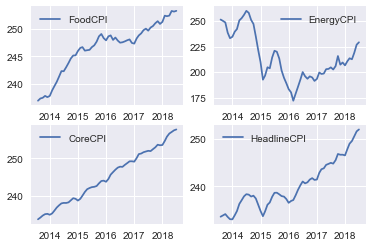

In [ ]:
y1=cpis['FoodCPI']
y2=cpis['EnergyCPI']
y3=cpis['CoreCPI']
y4=cpis['HeadlineCPI']
x=cpis.index

plt.subplot(221)
plt.plot(x, y1)
plt.legend(loc='best')

plt.subplot(222)
plt.plot(x, y2)
plt.legend(loc='best')

plt.subplot(223)
plt.plot(x, y3)
plt.legend(loc='best')

plt.subplot(224)
plt.plot(x, y4)
plt.legend(loc='best')

plt.show()

Here we just break the changes in to a monthly percentage change. You can see the core inflation there is a certain amount of oscilation. This is owing to the seasonaility of inflation. Prices exhibit a certain predictability at various times of the year.

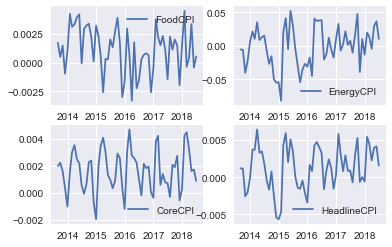

In [ ]:
y1=cpisp['FoodCPI']
y2=cpisp['EnergyCPI']
y3=cpisp['CoreCPI']
y4=cpisp['HeadlineCPI']
x=cpisp.index

plt.subplot(221)
plt.plot(x, y1)
plt.legend(loc='best')

plt.subplot(222)
plt.plot(x, y2)
plt.legend(loc='best')

plt.subplot(223)
plt.plot(x, y3)
plt.legend(loc='best')

plt.subplot(224)
plt.plot(x, y4)
plt.legend(loc='best')

plt.show()

Here I am showing the average monthly change for each of the sub components, you can see that the variance is much higher in energy than food and core.

In [ ]:
print(" Average monthly change Food Inflation",round(y1.mean()*100,3),"%")
print(" Average monthly change Energy Inflation",round(y2.mean()*100,3),"%")

print(" Average monthly change Core Inflation",round(y3.mean()*100,3),"%")

print(" Monthly Standard deviation of change  in Food Inflation",round(y1.std()*100,3),"%")
print(" Monthly Standard deviation of change  in Energy Inflation",round(y2.std()*100,3),"%")
print(" Monthly Standard deviation of change  in Core Inflation",round(y3.std()*100,3),"%")

 Average monthly change Food Inflation 0.113 %
 Average monthly change Energy Inflation -0.113 %
 Average monthly change Core Inflation 0.165 %
 Monthly Standard deviation of change  in Food Inflation 0.196 %
 Monthly Standard deviation of change  in Energy Inflation 2.983 %
 Monthly Standard deviation of change  in Core Inflation 0.153 %


Here i just want to show how the cpi actually fits together. You can see that the weights of each subcomponent add up to 1. So the change in each sub index is multiplied by its weight in the basket and all those changes are summed together to get the total basket change. For this exercise I just focused on Food, Energy and Core. Each of those can be further broken down, I have supplied the further breakdown in the attached sheet, but for the sake of this presentation it may not be necessary to go that deep. What i do here is calculated the headline cpi based on food, energy and core, and then i compare my calulation to the headline cpi and you can see the differences are very small.

In [ ]:
weight.columns = ['Weight of Food','Weight of Energy',' Weight of Core']
weight.head()

,Weight of Food,Weight of Energy,Weight of Core
2013-07-31 00:00:00,14.163,10.118,75.719
2013-08-31 00:00:00,14.17,10.052,75.778
2013-09-30 00:00:00,14.161,9.98,75.86
2013-10-31 00:00:00,14.218,9.603,76.179
2013-11-30 00:00:00,14.233,9.406,76.361


In [ ]:
weight= weight/100 # to convert everythign to %. Each row should sum to 1 %.
weight = weight.iloc[1:] #remove the first row as it is not comparable
weight.head()

,Weight of Food,Weight of Energy,Weight of Core
2013-08-31 00:00:00,0.1417,0.10052,0.75778
2013-09-30 00:00:00,0.14161,0.0998,0.7586
2013-10-31 00:00:00,0.14218,0.09603,0.76179
2013-11-30 00:00:00,0.14233,0.09406,0.76361
2013-12-31 00:00:00,0.13891,0.09046,0.77063


In [ ]:
cpis_main = cpisp[['FoodCPI','EnergyCPI','CoreCPI']]
cpis_main.head()

,FoodCPI,EnergyCPI,CoreCPI
2013-08-31 00:00:00,0.001709,-0.005406,0.001993
2013-09-30 00:00:00,0.000489,-0.005992,0.002237
2013-10-31 00:00:00,0.001469,-0.040195,0.001619
2013-11-30 00:00:00,-0.000967,-0.022589,0.000344
2013-12-31 00:00:00,0.000959,0.006031,-0.001033


In [ ]:
dfcpicalc=pd.DataFrame(cpis_main.values*weight.values, columns=cpis_main.columns, index=cpis_main.index)
dfcpicalc['Headline Calc'] = dfcpicalc.sum(axis=1)
dfcpicalc.head()

,FoodCPI,EnergyCPI,CoreCPI,Headline Calc
2013-08-31 00:00:00,0.000242145,-0.000543449,0.00151043,0.001209
2013-09-30 00:00:00,6.91927e-05,-0.000597975,0.00169687,0.001168
2013-10-31 00:00:00,0.00020891,-0.00385993,0.00123297,-0.002418
2013-11-30 00:00:00,-0.00013762,-0.00212471,0.00026302,-0.001999
2013-12-31 00:00:00,0.000133274,0.000545547,-0.000796041,-0.000117


In [ ]:
cpidifference = dfcpicalc["Headline Calc"].subtract(cpisp["HeadlineCPI"], fill_value=0)
cpidifference=round(cpidifference*100,2)
cpidifference.head()

2013-08-31    0.00
2013-09-30    0.00
2013-10-31    0.02
2013-11-30    0.00
2013-12-31   -0.00
dtype: float64

In [ ]:
ecofactors.head()

,Gas Prices,Crude Oil,Stock Prices,Unemployment Rate,Labour Force Participation,Consumer Confidence,Industrial Production,Import Prices,Agricultural Commodities Index
2013-07-31 00:00:00,3.63,105.03,1685.73,7.3,64,81.01,101.51,138.9,654.304
2013-08-31 00:00:00,3.594,107.65,1632.97,7.2,63.4,81.76,104.26,139.4,656.647
2013-09-30 00:00:00,3.393,102.33,1681.55,7.2,63.2,80.2,103.65,139.8,650.138
2013-10-31 00:00:00,3.275,96.38,1756.54,7.2,62.9,72.38,102.52,138.9,634.107
2013-11-30 00:00:00,3.272,92.72,1805.81,6.9,62.9,72.03,102.3,137.7,628.477


In [ ]:
ecofactorsp.head()

,Gas Prices,Crude Oil,Stock Prices,Unemployment Rate,Labour Force Participation,Consumer Confidence,Industrial Production,Import Prices,Agricultural Commodities Index
2013-08-31 00:00:00,-0.009917,0.024945,-0.031298,-0.013699,-0.009375,0.009258,0.027091,0.003600,0.003581
2013-09-30 00:00:00,-0.055927,-0.049419,0.029749,0.000000,-0.003155,-0.019080,-0.005851,0.002869,-0.009913
2013-10-31 00:00:00,-0.034777,-0.058145,0.044596,0.000000,-0.004747,-0.097506,-0.010902,-0.006438,-0.024657
2013-11-30 00:00:00,-0.000916,-0.037975,0.028049,-0.041667,0.000000,-0.004836,-0.002146,-0.008639,-0.008878
2013-12-31 00:00:00,0.015587,0.061475,0.023563,-0.028986,-0.004769,0.076496,0.003226,0.000726,-0.034840


In [ ]:
trace_gas = go.Scatter(x=ecofactorsp.index,
                y=ecofactorsp['Gas Prices'], name = "Gas Prices",
                line = dict(color = 'blue'),opacity = 0.8)

trace_oil = go.Scatter(x=ecofactorsp.index,
                y=ecofactorsp['Crude Oil'], name = "Crude Oil",
                line = dict(color = 'cyan'), opacity = 0.8)

trace_stock = go.Scatter(x=ecofactorsp.index,
                y=ecofactorsp['Stock Prices'], name = "Stock Prices",
                line = dict(color = 'gold'), opacity = 0.8)

trace_unemp = go.Scatter(x=ecofactorsp.index,
                y=ecofactorsp['Unemployment Rate'], name = "Unemployment Rate",
                line = dict(color = 'brown'), opacity = 0.8)

trace_labor = go.Scatter(x=ecofactorsp.index,
                y=ecofactorsp['Labour Force Participation'], name = "Labour Force Participation",
                line = dict(color = 'red'), opacity = 0.8)

trace_conso = go.Scatter(x=ecofactorsp.index,
                y=ecofactorsp['Consumer Confidence'], name = "Consumer Confidence",
                line = dict(color = 'orange'), opacity = 0.8)

trace_indus = go.Scatter(x=ecofactorsp.index,
                y=ecofactorsp['Industrial Production'], name = "Industrial Production",
                line = dict(color = 'grey'), opacity = 0.8)

trace_import = go.Scatter(x=ecofactorsp.index,
                y=ecofactorsp['Import Prices'], name = "Import Prices",
                line = dict(color = 'green'), opacity = 0.8)

trace_agro = go.Scatter(x=ecofactorsp.index,
                y=ecofactorsp['Agricultural Commodities Index'], name = "Agricultural Commodities Index",
                line = dict(color = 'chartreuse'), opacity = 0.8)

data = [trace_gas,trace_oil,trace_stock,trace_unemp,trace_labor,trace_conso,trace_indus,trace_import,trace_agro]
layout = go.Layout(title='Monthly Change of Economic Indicators, 2013 to 2018',xaxis=dict(title='Periods'),
                   yaxis=dict(title='Monthly Change in the Indicator'))

fig = dict(data=data,layout = layout)
py.iplot(fig, filename = "Monthly Change of Economic Indicators, 2013 to 2018")

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~MuhammadMazid/0 or inside your plot.ly account where it is named 'Monthly Change of Economic Indicators, 2013 to 2018'


In [ ]:
trace_gas = go.Scatter(x=ecofactors.index,
                y=ecofactors['Gas Prices'], name = "Gas Prices",
                line = dict(color = 'blue'),opacity = 0.8)

trace_oil = go.Scatter(x=ecofactors.index,
                y=ecofactors['Crude Oil'], name = "Crude Oil",
                line = dict(color = 'cyan'), opacity = 0.8)

trace_stock = go.Scatter(x=ecofactors.index,
                y=ecofactors['Stock Prices'], name = "Stock Prices",
                line = dict(color = 'gold'), opacity = 0.8)

trace_unemp = go.Scatter(x=ecofactors.index,
                y=ecofactors['Unemployment Rate'], name = "Unemployment Rate",
                line = dict(color = 'brown'), opacity = 0.8)

trace_labor = go.Scatter(x=ecofactors.index,
                y=ecofactors['Labour Force Participation'], name = "Labour Force Participation",
                line = dict(color = 'red'), opacity = 0.8)

trace_conso = go.Scatter(x=ecofactors.index,
                y=ecofactors['Consumer Confidence'], name = "Consumer Confidence",
                line = dict(color = 'orange'), opacity = 0.8)

trace_indus = go.Scatter(x=ecofactors.index,
                y=ecofactors['Industrial Production'], name = "Industrial Production",
                line = dict(color = 'grey'), opacity = 0.8)

trace_import = go.Scatter(x=ecofactors.index,
                y=ecofactors['Import Prices'], name = "Import Prices",
                line = dict(color = 'green'), opacity = 0.8)

trace_agro = go.Scatter(x=ecofactors.index,
                y=ecofactors['Agricultural Commodities Index'], name = "Agricultural Commodities Index",
                line = dict(color = 'chartreuse'), opacity = 0.8)

data = [trace_gas,trace_oil,trace_stock,trace_unemp,trace_labor,trace_conso,trace_indus,trace_import,trace_agro]
layout = go.Layout(title='Evolution of Key Economic Indicators, 2013 to 2018',xaxis=dict(title='Periods'),
                   yaxis=dict(title='Value of the Indicator'))

fig = dict(data=data,layout = layout)
py.iplot(fig, filename = "Economic Indicators, 2013 to 2018")

In [ ]:
data = [trace_gas,trace_oil,trace_unemp,trace_labor,trace_conso,trace_indus,trace_import]
layout = go.Layout(title='Evolution of Key Economic Indicators without Stocks and Agricultural Commodities, 2013 to 2018',xaxis=dict(title='Periods'),
                   yaxis=dict(title='Value of the Indicator'))
fig = dict(data=data,layout = layout)
py.iplot(fig, filename = "Economic Indicators no stock or commo, 2013 to 2018")

As an example here, we regress the price of gasoline, found in the economic variables tab, vs the energy component of CPI. There is all kind of different relationships we can look at. But food and energy shoudl correlate close to the food and energy components of cpi

In [ ]:
Gas=ecofactorsp['Gas Prices']
Energycpi=cpisp['EnergyCPI']
dfEnergy=pd.concat([Gas, Energycpi],axis=1)
dfEnergy.head()

,Gas Prices,EnergyCPI
2013-08-31,-0.009917,-0.005406
2013-09-30,-0.055927,-0.005992
2013-10-31,-0.034777,-0.040195
2013-11-30,-0.000916,-0.022589
2013-12-31,0.015587,0.006031


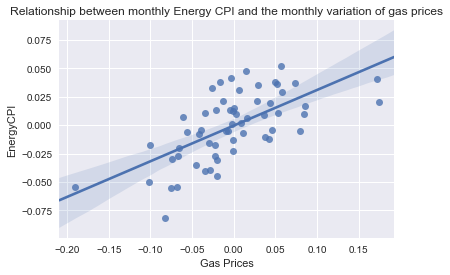

In [ ]:
sns.regplot(y="EnergyCPI", x="Gas Prices", data=dfEnergy, fit_reg = True)
plt.title("Relationship between monthly Energy CPI and the monthly variation of gas prices")

In [ ]:
model1=ols("Energycpi ~ Gas",data=dfEnergy).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              Energycpi   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     41.10
Date:                Tue, 24 Jul 2018   Prob (F-statistic):           3.03e-08
Time:                        13:20:33   Log-Likelihood:                 140.03
No. Observations:                  59   AIC:                            -276.1
Df Residuals:                      57   BIC:                            -271.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0004      0.003     -0.146      0.8

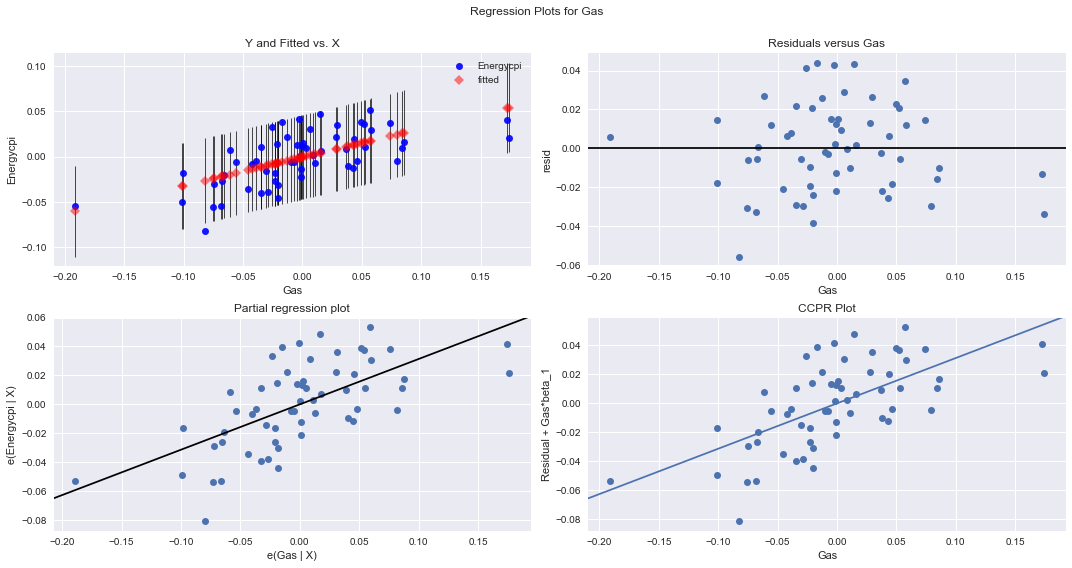

In [ ]:
fig=plt.figure(figsize=(15,8))
fig=sm.graphics.plot_regress_exog(model1,"Gas", fig=fig)

#           Forecasting Using ARIMAX

Our question is to see if the economic factors that we have extracted from Bloomberg could help predict CPI, the CPI headline or subcomponents of the CPI.

1)  we are going to fist investigate if we could use a simple and multilinear regression to the data

2)  then we will check the assumptions of linear regression
  * linearity between independent and dependent variable using a scatter plot (a lot of plots to do)
  * check for outliers?
  * need to be multivariate normal (independent variables) (histogram or Q-Q plot)
  * colinearity of the independent variables
  * autocorrelation
  * homoscedasticity (residuals are equal across the regression line)
  
3) try ARIMA

In [ ]:
#Note: for some obscure reasons corr does not work on the current form of ecofactors as imported above, so it requires
#a new import for the moment
ecofactors = pd.read_csv( path + "/economicFactors.csv")
ecofactors.head()

,Dates,Gas Prices,Crude Oil,Stock Prices,Unemployment Rate,Labour Force Participation,Consumer Confidence,Industrial Production,Import Prices,Agricultural Commodities Index
0,2013-07-31,3.630,105.03,1685.73,7.3,64.0,81.01,101.51,138.9,654.3037
1,2013-08-31,3.594,107.65,1632.97,7.2,63.4,81.76,104.26,139.4,656.6469
2,2013-09-30,3.393,102.33,1681.55,7.2,63.2,80.20,103.65,139.8,650.1375
3,2013-10-31,3.275,96.38,1756.54,7.2,62.9,72.38,102.52,138.9,634.1072
4,2013-11-30,3.272,92.72,1805.81,6.9,62.9,72.03,102.30,137.7,628.4775


In [ ]:
#Compute the correlations between all economic factors
corr = ecofactors.corr()
corr

,Gas Prices,Crude Oil,Stock Prices,Unemployment Rate,Labour Force Participation,Consumer Confidence,Industrial Production,Import Prices,Agricultural Commodities Index
Gas Prices,1.000000,0.973988,-0.384066,0.697173,0.422045,-0.491554,0.300192,0.955650,0.762014
Crude Oil,0.973988,1.000000,-0.428860,0.745316,0.369624,-0.528582,0.243230,0.970217,0.792105
Stock Prices,-0.384066,-0.428860,1.000000,-0.887423,-0.117998,0.941141,0.310596,-0.467513,-0.812503
Unemployment Rate,0.697173,0.745316,-0.887423,1.000000,0.246147,-0.909168,-0.108794,0.781812,0.940516
Labour Force Participation,0.422045,0.369624,-0.117998,0.246147,1.000000,-0.131511,0.175672,0.333952,0.231959
Consumer Confidence,-0.491554,-0.528582,0.941141,-0.909168,-0.131511,1.000000,0.274646,-0.567617,-0.858830
Industrial Production,0.300192,0.243230,0.310596,-0.108794,0.175672,0.274646,1.000000,0.320055,-0.077023
Import Prices,0.955650,0.970217,-0.467513,0.781812,0.333952,-0.567617,0.320055,1.000000,0.819805
Agricultural Commodities Index,0.762014,0.792105,-0.812503,0.940516,0.231959,-0.858830,-0.077023,0.819805,1.000000


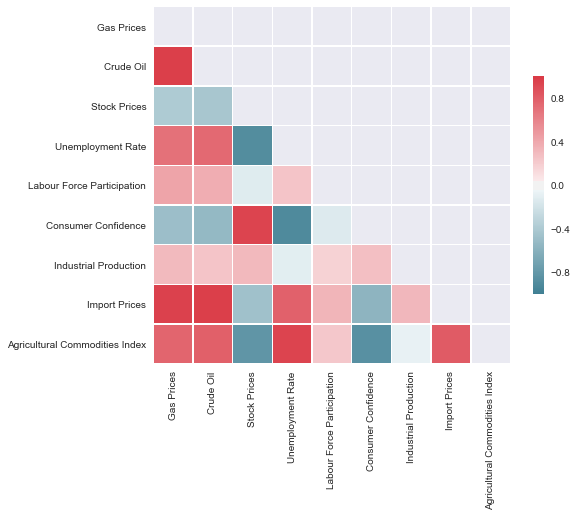

In [ ]:
#plot the results

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap = cmap , center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

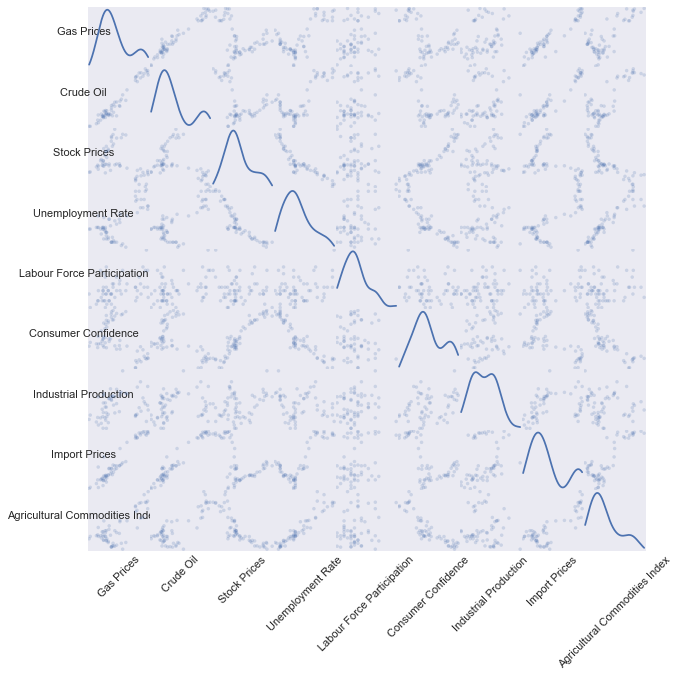

In [ ]:
#### scatter plot to detect colinearity between the independent variables
sm = pd.scatter_matrix(ecofactors, alpha=0.2, figsize=(10, 10), diagonal='kde')

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
#[s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

## scatter plot:
We can observe a strong linear relationship between


positive correlation:
Gas prices and Crude Oil

Gas prices and Import Prices

Crude oil and Import Prices

Stock Price and Labour Force Participation

Consumer Confidence and Stock price

Agricultural Commodities index and Unemployment rate

Negative correlation:

Stock Prices and Unemployment Rate

Unemployment rate and Labour Force Participation

Consumer Confidence and Stock Price

Many of these correlations make sense if we think of what they are (eg negative correlation between unemployment rate and labour force participation, or the positive correlation between Gas price and Crude Oil).


We are looking for these colinearity between these variables to see if all are needed to be incorporting in the forecasting model or if one is dominant over other and could explain all the other ones (eg import price) which shows the strongest correlation (positive or negative) with the other variables.

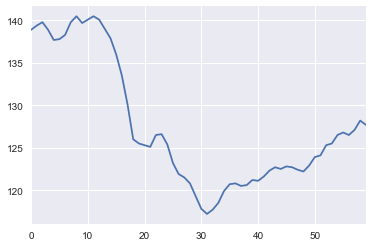

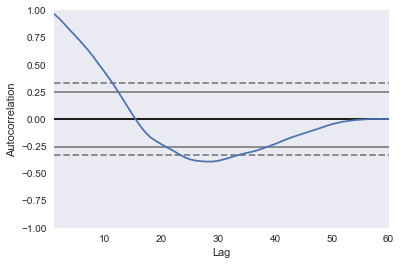

In [ ]:
series = ecofactors['Import Prices']
series.plot()
plt.show()
autocorrelation_plot(series)

In [ ]:
########### CPIs ################################################

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]

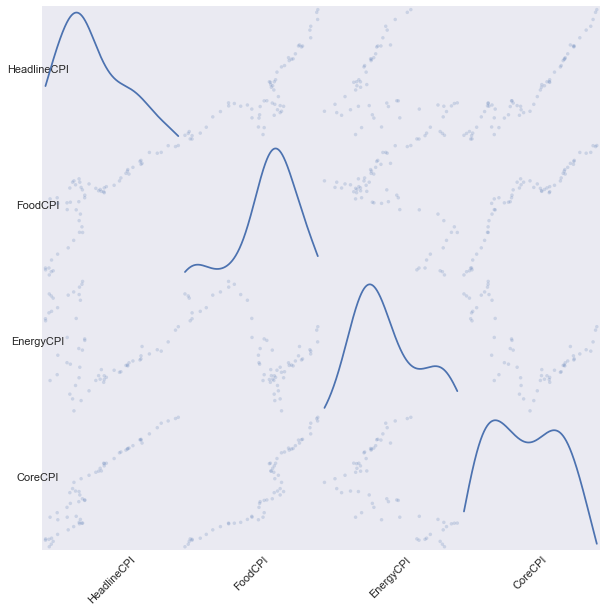

In [ ]:
#### scatter plot to detect colinearity between the independent variables
cpis = pd.read_csv( path + "/CPIs.csv")
sm = pd.scatter_matrix(cpis, alpha=0.2, figsize=(10, 10), diagonal='kde')

#Change label rotation
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

,HeadlineCPI,FoodCPI,EnergyCPI,CoreCPI
HeadlineCPI,1.000000,0.854610,-0.200222,0.930271
FoodCPI,0.854610,1.000000,-0.483558,0.956931
EnergyCPI,-0.200222,-0.483558,1.000000,-0.461357
CoreCPI,0.930271,0.956931,-0.461357,1.000000


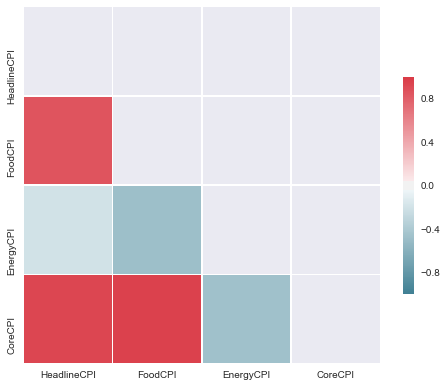

In [ ]:
corr = cpis.corr(method='spearman')

#pd.plotting.scatter_matrix(economical)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap = cmap , center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr

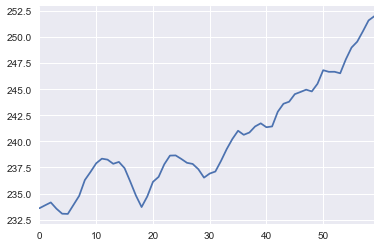

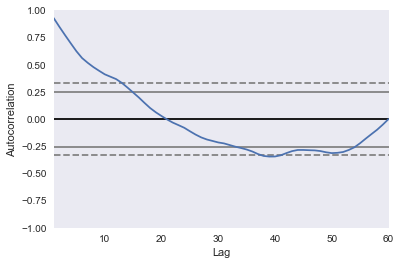

In [ ]:
from pandas.plotting import autocorrelation_plot

series = cpis['HeadlineCPI']
series.plot()
plt.show()
autocorrelation_plot(series)

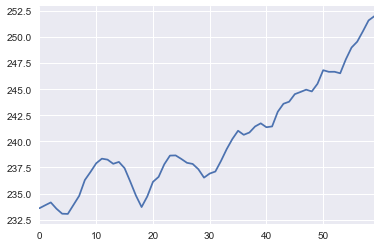

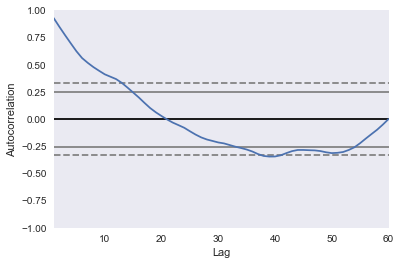

In [ ]:
from pandas.plotting import autocorrelation_plot

series = cpis['HeadlineCPI']
series.plot()
plt.show()
autocorrelation_plot(series)

In [ ]:
#Merge the 2 data sets to perform ARIMAX.
ecofactors.columns = ecofactors.columns.str.replace(' ', '') #remove spaces in the column titles to avoid naming issues
CPI_ecofactors = pd.merge(cpis, ecofactors, on='Dates') # merge the 2 datasets
CPI_ecofactors.head()

,Dates,HeadlineCPI,FoodCPI,EnergyCPI,CoreCPI,GasPrices,CrudeOil,StockPrices,UnemploymentRate,LabourForceParticipation,ConsumerConfidence,IndustrialProduction,ImportPrices,AgriculturalCommoditiesIndex
0,2013-07-31,233.596,237.001,251.370,233.792,3.630,105.03,1685.73,7.3,64.0,81.01,101.51,138.9,654.3037
1,2013-08-31,233.877,237.406,250.011,234.258,3.594,107.65,1632.97,7.2,63.4,81.76,104.26,139.4,656.6469
2,2013-09-30,234.149,237.522,248.513,234.782,3.393,102.33,1681.55,7.2,63.2,80.20,103.65,139.8,650.1375
3,2013-10-31,233.546,237.871,238.524,235.162,3.275,96.38,1756.54,7.2,62.9,72.38,102.52,138.9,634.1072
4,2013-11-30,233.069,237.641,233.136,235.243,3.272,92.72,1805.81,6.9,62.9,72.03,102.30,137.7,628.4775


### Modeling the headline CPI

modeling with all variables:

In [ ]:
model = pf.ARIMAX(data=CPI_ecofactors, formula='HeadlineCPI~1+GasPrices+ CrudeOil+ UnemploymentRate + LabourForceParticipation +ConsumerConfidence+ IndustrialProduction+ ImportPrices+ AgriculturalCommoditiesIndex',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: HeadlineCPI                         Method: MLE                                       
Start Date: 1                                           Log Likelihood: -43.8644                          
End Date: 59                                            AIC: 111.7288                                     
Number of observations: 59                              BIC: 136.6592                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.9239     0.0887     10.4182  0.0      (0.7501 | 1.0977)        
MA(1)                                

modeling with the top 2 variables : gas price and import prices:

In [ ]:
model = pf.ARIMAX(data=CPI_ecofactors, formula='HeadlineCPI ~ 1 + GasPrices + ImportPrices',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: HeadlineCPI                         Method: MLE                                       
Start Date: 1                                           Log Likelihood: -44.5591                          
End Date: 59                                            AIC: 101.1182                                     
Number of observations: 59                              BIC: 113.5835                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.9893     0.0212     46.7564  0.0      (0.9478 | 1.0308)        
MA(1)                                

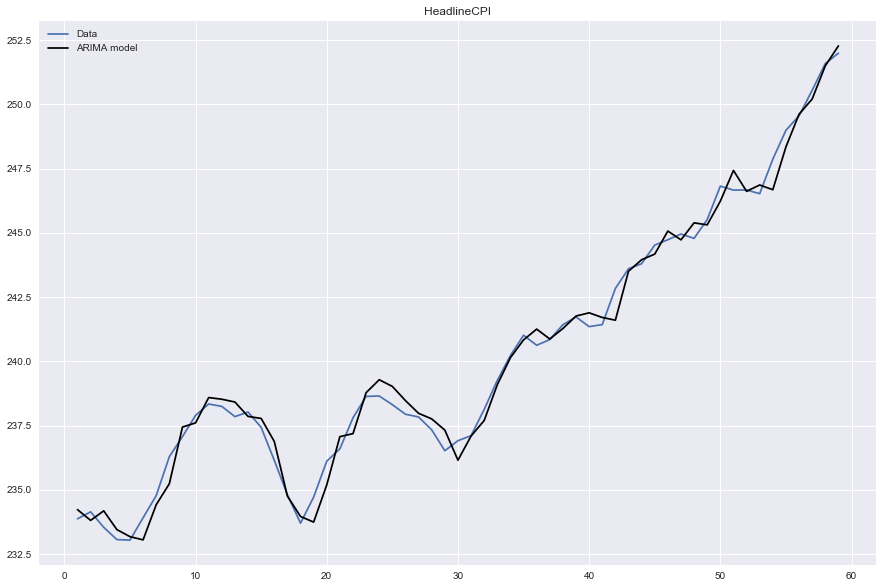

In [ ]:
model.plot_fit(figsize=(15,10))


x axis+ dates from 2013 to 2018

y axis: headline CPI

#### Modeling of the FOOD CPI

In [ ]:
model = pf.ARIMAX(data=CPI_ecofactors, formula='FoodCPI ~ 1+GasPrices+ CrudeOil+ UnemploymentRate + LabourForceParticipation +ConsumerConfidence+ IndustrialProduction+ ImportPrices+ AgriculturalCommoditiesIndex',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()


Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: FoodCPI                             Method: MLE                                       
Start Date: 1                                           Log Likelihood: -33.3176                          
End Date: 59                                            AIC: 90.6353                                      
Number of observations: 59                              BIC: 115.5657                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.9855     0.1033     9.5444   0.0      (0.7831 | 1.1878)        
MA(1)                                

None of the independent variables are associated with pvalue <=0.05 .

### Modeling the CORE CPI

modeling the CORE cpi with all variables:

In [ ]:
model = pf.ARIMAX(data=CPI_ecofactors, formula='CoreCPI~1+GasPrices+ CrudeOil+ UnemploymentRate + LabourForceParticipation +ConsumerConfidence+ IndustrialProduction+ ImportPrices+ AgriculturalCommoditiesIndex',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()


Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: CoreCPI                             Method: MLE                                       
Start Date: 1                                           Log Likelihood: -13.7766                          
End Date: 59                                            AIC: 51.5531                                      
Number of observations: 59                              BIC: 76.4836                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    1.077      0.0529     20.3549  0.0      (0.9733 | 1.1807)        
MA(1)                                

modeling with variables with pvalue <= 0.05 (Unemployment rate and LabourForceParticipation):

In [ ]:
model = pf.ARIMAX(data=CPI_ecofactors, formula='CoreCPI~1+UnemploymentRate + LabourForceParticipation ',ar=1, ma=1, family=pf.Normal())

x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: CoreCPI                             Method: MLE                                       
Start Date: 1                                           Log Likelihood: -14.5724                          
End Date: 59                                            AIC: 41.1448                                      
Number of observations: 59                              BIC: 53.6101                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    1.032      0.0321     32.1969  0.0      (0.9692 | 1.0948)        
MA(1)                                

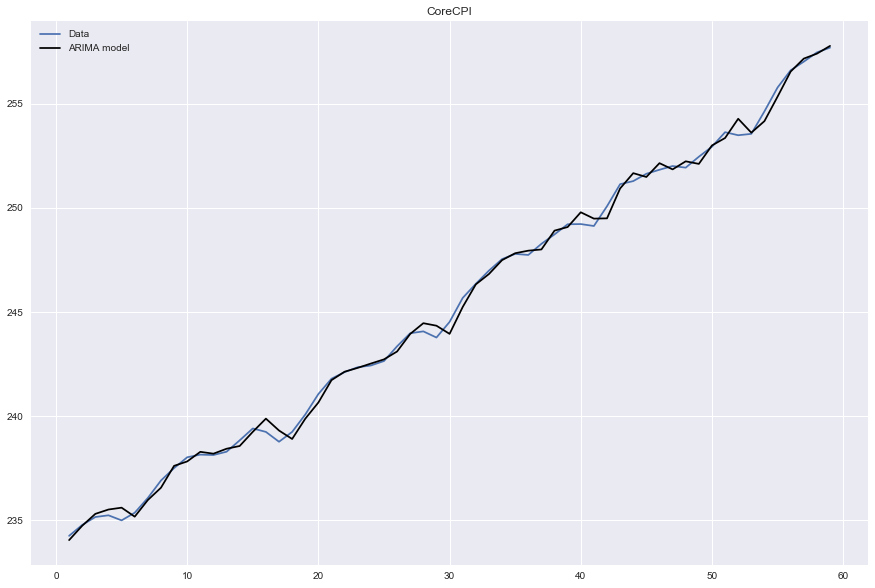

In [ ]:
model.plot_fit(figsize=(15,10))

We ended up removing unemployement as well as p-value increased to 32%. This may be due to our previous observation that the 2 variable are strongly correlated.

In [ ]:
model = pf.ARIMAX(data=CPI_ecofactors, formula='CoreCPI~1+ LabourForceParticipation ',ar=1, ma=1, family=pf.Normal())

x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: CoreCPI                             Method: MLE                                       
Start Date: 1                                           Log Likelihood: -15.0579                          
End Date: 59                                            AIC: 40.1157                                      
Number of observations: 59                              BIC: 50.5034                                      
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    1.0019     0.0091     109.5668 0.0      (0.984 | 1.0198)         
MA(1)                                

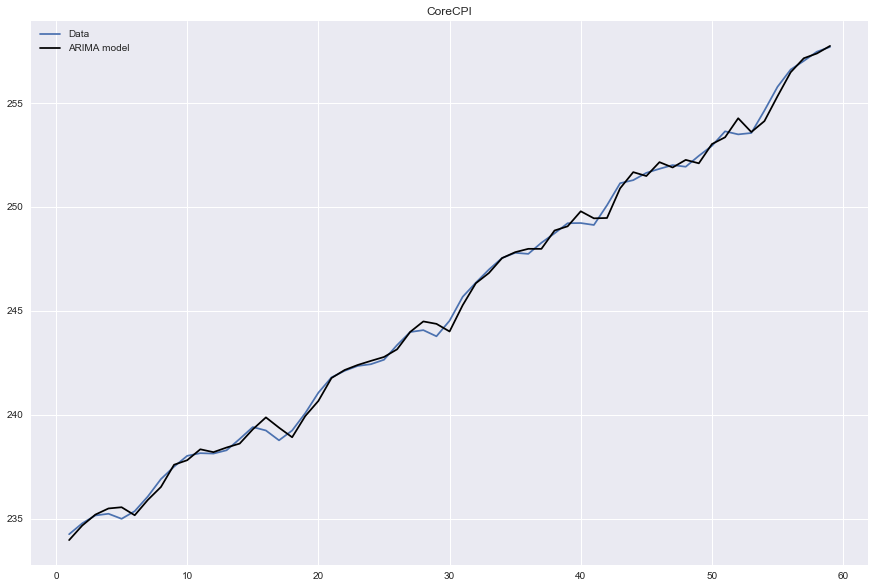

In [ ]:
model.plot_fit(figsize=(15,10))

x axis : data from 2013 to 2018
y axis: CORE CPI

## Modeling the energy CPI

modeling with all variables:

In [ ]:
model = pf.ARIMAX(data=CPI_ecofactors, formula='EnergyCPI~1+GasPrices+ CrudeOil+ UnemploymentRate + LabourForceParticipation +ConsumerConfidence+ IndustrialProduction+ ImportPrices+ AgriculturalCommoditiesIndex',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()


Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: EnergyCPI                           Method: MLE                                       
Start Date: 1                                           Log Likelihood: -136.1221                         
End Date: 59                                            AIC: 296.2442                                     
Number of observations: 59                              BIC: 321.1746                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.4762     0.0518     9.1971   0.0      (0.3747 | 0.5776)        
MA(1)                                

modeling with the variables associated with pvalue <= 0.05: Gas Prices, Crude Oil and Unemployment Rate:

In [ ]:
model = pf.ARIMAX(data=CPI_ecofactors, formula='EnergyCPI~1+GasPrices+ CrudeOil+ UnemploymentRate ',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: EnergyCPI                           Method: MLE                                       
Start Date: 1                                           Log Likelihood: -134.7392                         
End Date: 59                                            AIC: 283.4784                                     
Number of observations: 59                              BIC: 298.0212                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.4291     0.022      19.517   0.0      (0.386 | 0.4722)         
MA(1)                                

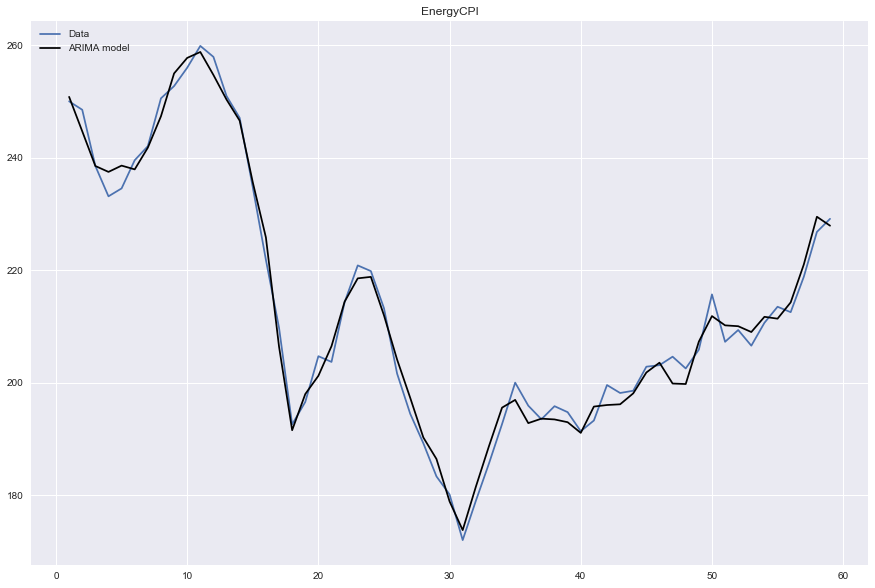

In [ ]:
model.plot_fit(figsize=(15,10))

x axis: dates from 2013 to 2018.

y axis: energy CPI

### TRAIN THE  DATA: data from 2013 and 2016 inclusive

In [ ]:
training_filter = CPI_ecofactors.Dates < "2017-01-01"
CPI_ecofactors_training = CPI_ecofactors[training_filter]

In [ ]:
model2 = pf.ARIMAX(data=CPI_ecofactors_training, formula='EnergyCPI~1+GasPrices+ CrudeOil+ UnemploymentRate ',
                  ar=1, ma=1, family=pf.Normal())
x = model2.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: EnergyCPI                           Method: MLE                                       
Start Date: 1                                           Log Likelihood: -90.2756                          
End Date: 41                                            AIC: 194.5513                                     
Number of observations: 41                              BIC: 206.5463                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.42       0.0193     21.7285  0.0      (0.3821 | 0.4579)        
MA(1)                                

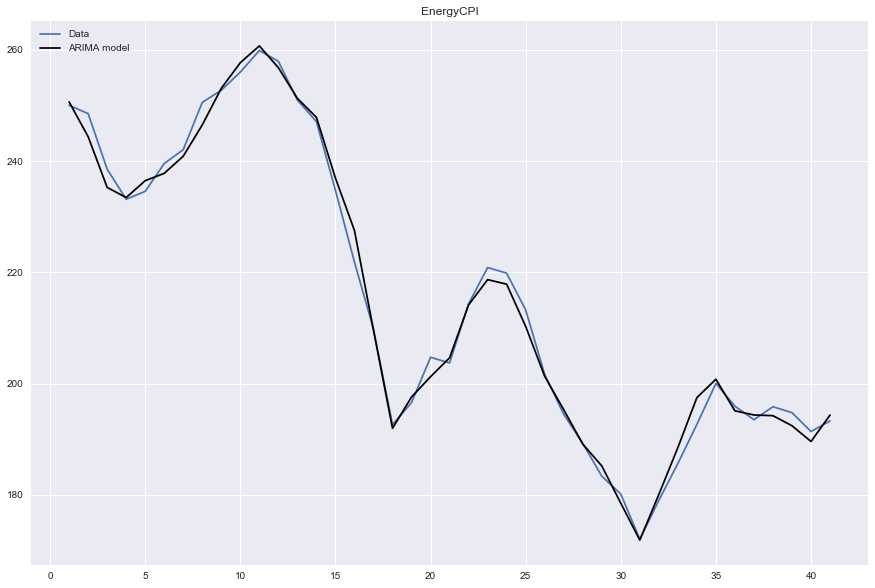

In [ ]:
model2.plot_fit(figsize=(15,10))

## Forecast using the validation data: data from 2017 and 2018

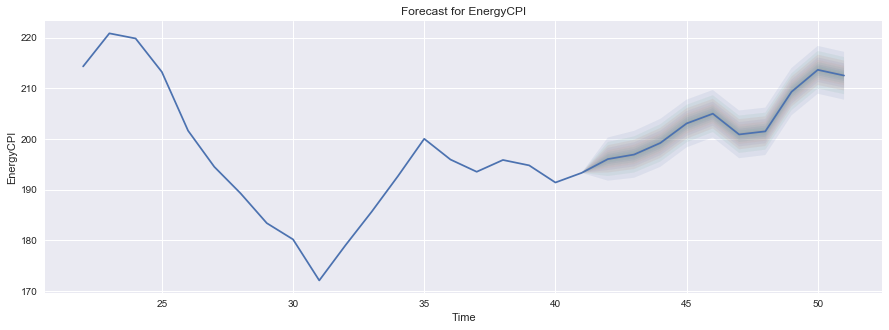

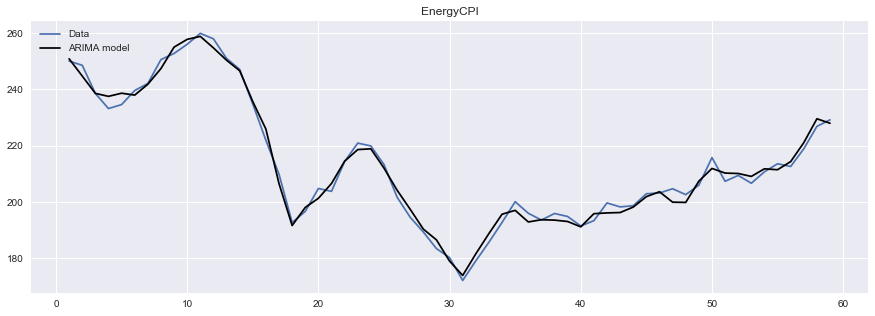

In [ ]:
CPI_ecofactors_validation = CPI_ecofactors[~training_filter]
model2.plot_predict(h=10, oos_data=CPI_ecofactors_validation,  figsize=(15,5))
model.plot_fit(figsize=(15,5) )
plt.show()

The first plot shows the modeling of the energy CPI from 2013 to 2016 and the forecasting of the energy CPI from 2017 and 2018 (from 45 to 55). x axis representes each date points and the y axis represents the energy CPI.  If we compare with the modeling on the entire dataset (from 2013 to 2018) (second plot), we can see an adequate forecasting of the model for 2017/2018 (from 45 to 55).

###################################################################################
###################################################################################

Reference code used for ARIMAX:

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

Forecast using k-nearest neighbors

Modeling the energy CPI

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# training data set
x_columns = np.array(CPI_ecofactors_training[['GasPrices','CrudeOil','UnemploymentRate']])
y_column = CPI_ecofactors_training['EnergyCPI']

# test data set
z_columns = np.array(CPI_ecofactors[['GasPrices','CrudeOil','UnemploymentRate']])

# Look at the five closest neighbors.
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data.
knn.fit(x_columns, y_column)

# Make point predictions on the test set using the fit model.
predictions = knn.predict(z_columns)


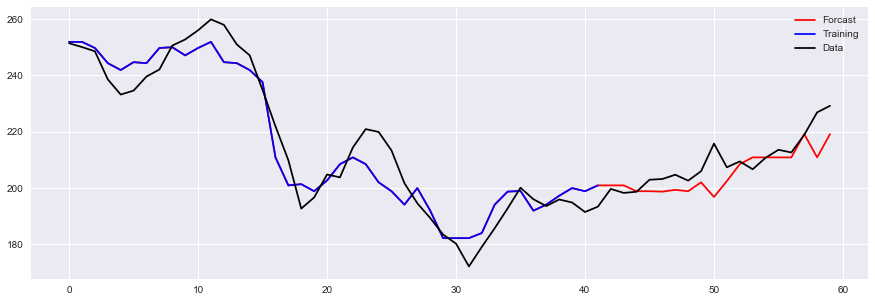

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(predictions, label='Forcast', color='r')
plt.plot(predictions[training_filter], label='Training', color='b')
plt.plot(CPI_ecofactors['EnergyCPI'], label='Data', color='black')

plt.legend(loc='upper right')
plt.show()

Modeling the CoreCPI

In [ ]:
# training data set
x_columns = np.array(CPI_ecofactors_training[['UnemploymentRate','LabourForceParticipation']])
y_column = CPI_ecofactors_training['CoreCPI']

# test data set
z_columns = np.array(CPI_ecofactors[['UnemploymentRate','LabourForceParticipation']])

# Look at the five closest neighbors.
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data.
knn.fit(x_columns, y_column)

# Make point predictions on the test set using the fit model.
predictions = knn.predict(z_columns)


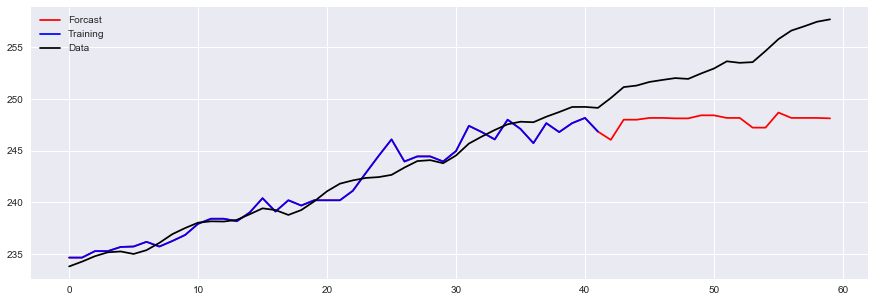

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(predictions, label='Forcast', color='r')
plt.plot(predictions[training_filter], label='Training', color='b')
plt.plot(CPI_ecofactors['CoreCPI'], label='Data', color='black')

plt.legend(loc='upper left')
plt.show()

Modeling the HeadlineCPI

In [ ]:
# Creating the training data set
x_columns = np.array(CPI_ecofactors_training[['GasPrices','ImportPrices']])
y_column = CPI_ecofactors_training['HeadlineCPI']

# Creating the test data set
z_columns = np.array(CPI_ecofactors[['GasPrices','ImportPrices']])

# Look at the five closest neighbors.
knn = KNeighborsRegressor(n_neighbors=5)

# Fit the model on the training data.
knn.fit(x_columns, y_column)

# Make point predictions on the test set using the fit model.
predictions = knn.predict(z_columns)


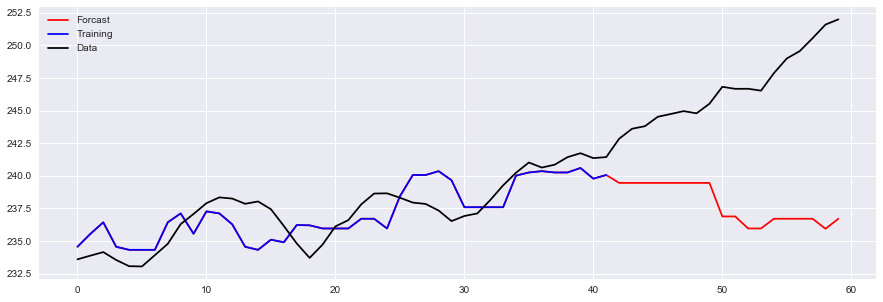

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(predictions, label='Forcast', color='r')
plt.plot(predictions[training_filter], label='Training', color='b')
plt.plot(CPI_ecofactors['HeadlineCPI'], label='Data', color='black')

plt.legend(loc='upper left')
plt.show()